In [19]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import random
import tensorflow as tf
import pickle

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load the data
file_path = '/home/bhikrant07/Desktop/AI/KU_STUDENT_DATA_ON_CAMPUS_PLACEMENT.csv'
data = pd.read_csv(file_path)

## Preprocess the data
1. Standardization for numerical features
2. One hot encoding for categorical features

In [20]:
data = data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

categorical_features = data.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical_data = encoder.fit_transform(data[categorical_features])

numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(data[numerical_features])

encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_features))
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_features)
processed_data = pd.concat([encoded_categorical_df, scaled_numerical_df], axis=1)

## Extracting the target variable

In [21]:
X_cgpa = processed_data.drop(['CGPA after 8th semester'], axis=1)
y_cgpa = processed_data['CGPA after 8th semester']

X_placement = processed_data.drop(['Cam_plc_yes'], axis=1)
y_placement = processed_data['Cam_plc_yes']

## Train_test_split & data reshaping for LSTM

In [22]:
X_train_cgpa, X_test_cgpa, y_train_cgpa, y_test_cgpa = train_test_split(X_cgpa, y_cgpa, test_size=0.2, random_state=42)
X_train_placement, X_test_placement, y_train_placement, y_test_placement = train_test_split(X_placement, y_placement, test_size=0.2, random_state=42)

# Reshape data for LSTM
X_train_cgpa_reshaped = np.reshape(X_train_cgpa.values, (X_train_cgpa.shape[0], X_train_cgpa.shape[1], 1))
X_test_cgpa_reshaped = np.reshape(X_test_cgpa.values, (X_test_cgpa.shape[0], X_test_cgpa.shape[1], 1))
X_train_placement_reshaped = np.reshape(X_train_placement.values, (X_train_placement.shape[0], X_train_placement.shape[1], 1))
X_test_placement_reshaped = np.reshape(X_test_placement.values, (X_test_placement.shape[0], X_test_placement.shape[1], 1))

In [56]:
from deap import base, creator, tools, algorithms
from keras.optimizers import Adam, RMSprop, SGD, Adadelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2


creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/home/bhikrant07/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/bhikrant07/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Functions for LSTM models of placement and cgpa 

In [55]:
def create_cgpa_model(units, activation, dropout, optimizer, learning_rate, dropout_rate=0.2, l2_penalty=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(X_train_cgpa_reshaped.shape[1], 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(l2_penalty)))
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
    return model

def create_placement_model(units, activation, dropout, optimizer, learning_rate, dropout_rate=0.5, l2_penalty=0.01):# changed l2, dropout_rate :0.2
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units, activation=activation, input_shape=(X_train_placement_reshaped.shape[1], 1))))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_penalty)))
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Define the fitness function

In [6]:
def evaluate_cgpa_model(individual):
    units = individual[0]
    activation = individual[1]
    dropout = individual[2]
    optimizer = individual[3]
    learning_rate = individual[4]
    
    model = create_cgpa_model(units, activation, dropout, optimizer, learning_rate)
    model.fit(X_train_cgpa_reshaped, y_train_cgpa, epochs=10, verbose=0)
    loss, mse = model.evaluate(X_test_cgpa_reshaped, y_test_cgpa, verbose=0)
    return mse,

def evaluate_placement_model(individual):
    units = individual[0]
    activation = individual[1]
    dropout = individual[2]
    optimizer = individual[3]
    learning_rate = individual[4]
    
    model = create_placement_model(units, activation, dropout, optimizer, learning_rate)
    model.fit(X_train_placement_reshaped, y_train_placement, epochs=10, verbose=0)
    loss, acc = model.evaluate(X_test_placement_reshaped, y_test_placement, verbose=0)
    return 1 - acc,

## Register GA Components

In [7]:
toolbox = base.Toolbox()
toolbox.register("attr_units", random.randint, 50, 200)
toolbox.register("attr_activation", random.choice, ['relu', 'tanh', 'sigmoid'])
toolbox.register("attr_dropout", random.uniform, 0.0, 0.5)
toolbox.register("attr_optimizer", random.choice, ['adam', 'rmsprop', 'sgd', 'adadelta'])
toolbox.register("attr_learning_rate", random.uniform, 1e-4, 1e-2)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_units, toolbox.attr_activation, toolbox.attr_dropout,
                  toolbox.attr_optimizer, toolbox.attr_learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)

In [ ]:
# Custom mutation function to ensure dropout rate remains within valid range
def custom_mutate(individual):
    individual[0] = random.randint(50, 200) if random.random() < 0.2 else individual[0]
    individual[1] = random.choice(['relu', 'tanh', 'sigmoid']) if random.random() < 0.2 else individual[1]
    individual[2] = max(0.0, min(1.0, individual[2] + random.gauss(0, 0.1))) if random.random() < 0.2 else individual[2]
    individual[3] = random.choice(['adam', 'rmsprop', 'sgd', 'adadelta']) if random.random() < 0.2 else individual[3]
    individual[4] = max(1e-4, min(1e-2, individual[4] + random.gauss(0, 0.001))) if random.random() < 0.2 else individual[4]
    return individual,

toolbox.register("mutate", custom_mutate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_cgpa_model)

### Run the Genetic Algorithm for CGPA Model

In [ ]:
population = toolbox.population(n=10)
ngen = 10
cxpb = 0.5
mutpb = 0.2

result_cgpa, logbook = algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, verbose=True)

best_individual_cgpa = tools.selBest(population, 1)[0]
print(f'Best CGPA Model Hyperparameters: {best_individual_cgpa}')

# Save best hyperparameters for CGPA model
with open('best_hyperparameters_cgpa.pkl', 'wb') as f:
    pickle.dump(best_individual_cgpa, f)

### Run the Genetic Algorithm for Placement Model

In [ ]:
toolbox.unregister("evaluate")
toolbox.register("evaluate", evaluate_placement_model)

population = toolbox.population(n=10)
result_placement, logbook = algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, verbose=True)

best_individual_placement = tools.selBest(population, 1)[0]
print(f'Best Placement Model Hyperparameters: {best_individual_placement}')

# Save best hyperparameters for Placement model
with open('best_hyperparameters_placement.pkl', 'wb') as f:
    pickle.dump(best_individual_placement, f)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

## Train the CGPA model with the best hyperparameters

In [26]:

best_units_cgpa = best_individual_cgpa[0]
best_activation_cgpa = best_individual_cgpa[1]
best_dropout_cgpa = best_individual_cgpa[2]
best_optimizer_cgpa = best_individual_cgpa[3]
best_learning_rate_cgpa = best_individual_cgpa[4]

final_cgpa_model = create_cgpa_model(best_units_cgpa, best_activation_cgpa, best_dropout_cgpa, best_optimizer_cgpa, best_learning_rate_cgpa)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_cgpa = final_cgpa_model.fit(
    X_train_cgpa_reshaped, y_train_cgpa, 
    epochs=100, 
    validation_data=(X_test_cgpa_reshaped, y_test_cgpa),
    callbacks=[early_stopping]
)

loss_cgpa, mse_cgpa = final_cgpa_model.evaluate(X_test_cgpa_reshaped, y_test_cgpa)
print('Final MSE for CGPA:', mse_cgpa)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8775 - mse: 0.8757 - val_loss: 0.7778 - val_mse: 0.7762
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6962 - mse: 0.6946 - val_loss: 4.0564 - val_mse: 4.0549
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.4612 - mse: 1.4598 - val_loss: 0.9607 - val_mse: 0.9595
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8024 - mse: 0.8012 - val_loss: 0.9073 - val_mse: 0.9061
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6857 - mse: 0.6845 - val_loss: 0.4045 - val_mse: 0.4032
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4882 - mse: 0.4869 - val_loss: 0.1710 - val_mse: 0.1696
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3551 - mse: 0.3538 - val_loss: 0.1473 - val_mse: 0.1459
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3173 - mse: 0.3159 - val_loss: 0.1460 - val_mse: 0.1446
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - lo

## Train the Placement model with the best hyperparameters

In [52]:
best_units_placement = best_individual_placement[0]
best_activation_placement = best_individual_placement[1]
best_dropout_placement = best_individual_placement[2]
best_optimizer_placement = best_individual_placement[3]
best_learning_rate_placement = best_individual_placement[4]

final_placement_model = create_placement_model(best_units_placement, best_activation_placement, best_dropout_placement, best_optimizer_placement, best_learning_rate_placement)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

history_placement = final_placement_model.fit(
    X_train_placement_reshaped, y_train_placement, 
    epochs=100, 
    validation_data=(X_test_placement_reshaped, y_test_placement),
    callbacks=[early_stopping]
)
loss_placement, acc_placement = final_placement_model.evaluate(X_test_placement_reshaped, y_test_placement)
print('Final Accuracy for Placement:', acc_placement)

Epoch 1/100


/home/bhikrant07/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5254 - loss: 0.8703 - val_accuracy: 0.5541 - val_loss: 0.7061
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5436 - loss: 0.7179 - val_accuracy: 0.5405 - val_loss: 0.7007
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5790 - loss: 0.6857 - val_accuracy: 0.5676 - val_loss: 0.6961
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5976 - loss: 0.6766 - val_accuracy: 0.6081 - val_loss: 0.6938
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6006 - loss: 0.6752 - val_accuracy: 0.6351 - val_loss: 0.6918
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6050 - loss: 0.6611 - val_accuracy: 0.6216 - val_loss: 0.6860
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6133 - loss: 0.6519 - val_accuracy: 0.6486 - val_loss: 0.6789
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6215 - loss: 0.6539 - val_accuracy: 0.6351 - val_loss

## Plotting ROC Curve for Placement Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


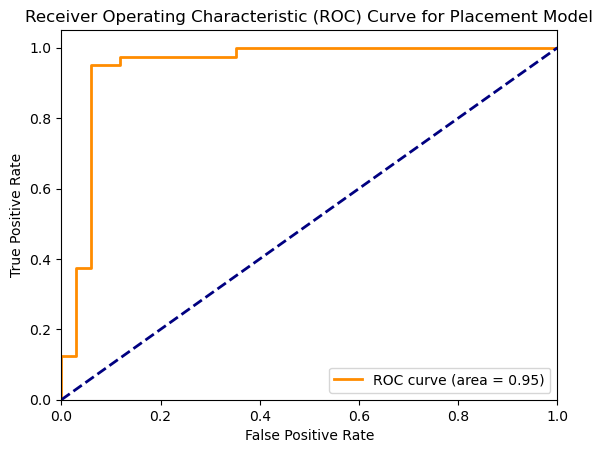

Optimal Threshold for Placement Prediction: 0.6065


In [53]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_prob_placement = final_placement_model.predict(X_test_placement_reshaped).ravel()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_placement, y_pred_prob_placement)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Placement Model')
plt.legend(loc='lower right')
plt.show()

# Find optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold for Placement Prediction: {optimal_threshold:.4f}')

In [54]:
final_cgpa_model.summary()
final_placement_model.summary()

Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_141 (LSTM)                 │ (None, 200)            │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485,405 (1.85 MB)

 Trainable params: 161,801 (632.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 323,604 (1.23 MB)

Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_84                │ (None, 174)            │        61,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 174)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 174)            │           696 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 1)              │           175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,751 (733.41 KB)

 Trainable params: 62,467 (244.01 KB)

 Non-trainable params: 348 (1.36 KB)

 Optimizer params: 124,936 (488.04 KB)

## Plot training loss vs validation loss for CGPA model

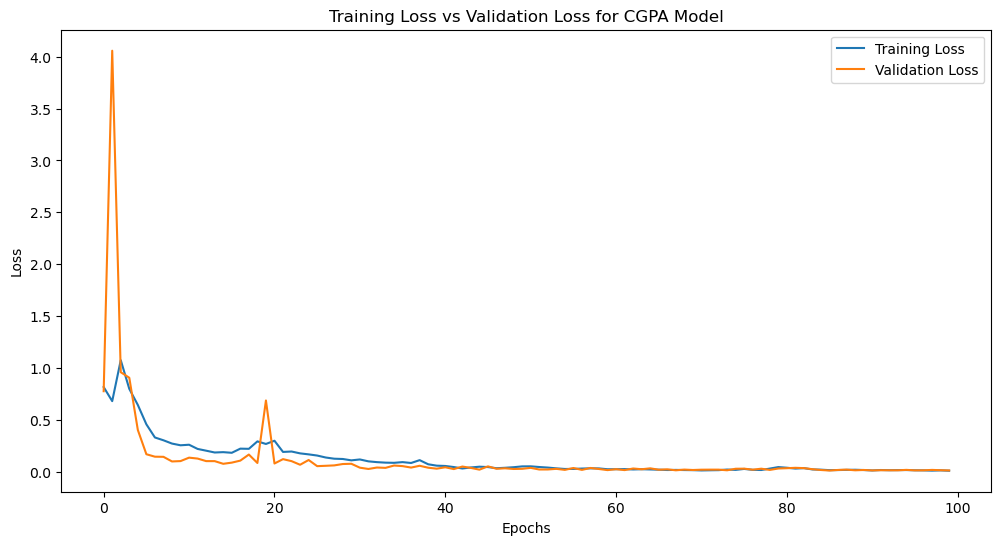

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(history_cgpa.history['loss'], label='Training Loss')
plt.plot(history_cgpa.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss for CGPA Model')
plt.legend()
plt.show()

## Plot training loss vs validation loss for Placement model

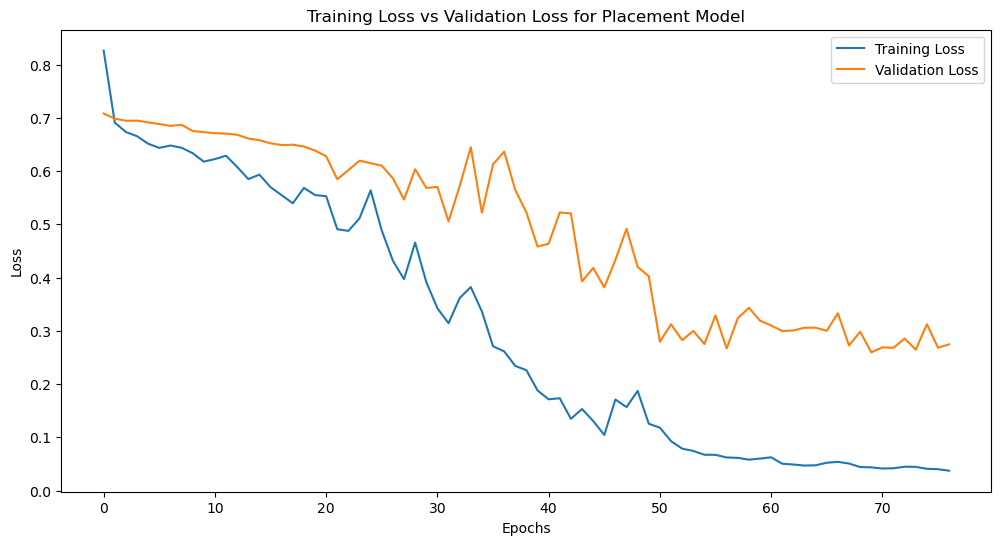

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(history_placement.history['loss'], label='Training Loss')
plt.plot(history_placement.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss for Placement Model')
plt.legend()
plt.show()

## Function for prediction

In [48]:
def predict_student_cgpa(student_index):
    student_data_a = X_cgpa.iloc[student_index]
    cgpa_input = np.array(student_data_a).reshape((1, len(student_data_a), 1))
    predicted_cgpa = final_cgpa_model.predict(cgpa_input)
    print('Predicted CGPA:', predicted_cgpa[0][0])

    # Inverse transform to get the predicted CGPA on the original scale
    y_cgpa = data['CGPA after 8th semester']
    y_train_cgpa = np.array(y_cgpa.values)
    scaler = StandardScaler()
    y_train_cgpa_scaled = scaler.fit_transform(y_train_cgpa.reshape(-1, 1)) 
    predicted_cgpa_original = scaler.inverse_transform(predicted_cgpa) 
    print('Predicted CGPA (original scale):', predicted_cgpa_original[0][0])

def predict_student_placement(student_index, threshold=optimal_threshold):
    student_data_b = X_placement.iloc[student_index]
    placement_input = np.array(student_data_b).reshape((1, len(student_data_b), 1))
    predicted_placement_prob = final_placement_model.predict(placement_input)
    predicted_placement = int(predicted_placement_prob >= threshold)
    print('Predicted Placement:', 'Yes' if predicted_placement == 1 else 'No')

In [49]:
# Test predictions for a student with index 0
predict_student_cgpa(0)
predict_student_placement(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted CGPA: -0.62029207
Predicted CGPA (original scale): 6.42751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Placement: Yes


/tmp/ipykernel_29745/3806690968.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_placement = int(predicted_placement_prob >= threshold)


In [45]:
#test 1
predict_student_cgpa(7)
predict_student_placement(7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted CGPA: 1.3231412
Predicted CGPA (original scale): 8.211971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted Placement: No


/tmp/ipykernel_29745/1528616677.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_placement = int(predicted_placement_prob >= threshold)


In [46]:
predict_student_cgpa(2)
predict_student_placement(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted CGPA: 0.19203423
Predicted CGPA (original scale): 7.173388
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted Placement: Yes


/tmp/ipykernel_29745/1528616677.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_placement = int(predicted_placement_prob >= threshold)


In [47]:
predict_student_cgpa(0)
predict_student_placement(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted CGPA: -0.62029207
Predicted CGPA (original scale): 6.42751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted Placement: Yes


/tmp/ipykernel_29745/1528616677.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_placement = int(predicted_placement_prob >= threshold)
